In [1]:
import torch.nn as nn
import torchvision
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
import torch
from torch.utils.data.dataloader import DataLoader
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

import matplotlib.pyplot as plt 
import numpy as np
import sys

In [2]:
# import model from the kuangliu repo 
from resnet import ResNet18

In [3]:
# hyperparameters
batch_size = 64
num_epochs = 30
learning_rate = 0.001
is_scheduler = True
weight = 0.0005
is_mixup = False

In [4]:
## Normalization adapted for CIFAR10
normalize_scratch = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

# Transforms is a list of transformations applied on the 'raw' dataset before the data is fed to the network.
# Here, Data augmentation (RandomCrop and Horizontal Flip) are applied to each batch, differently at each epoch, on the training set data only
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    normalize_scratch,
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    normalize_scratch,
])

### The data from CIFAR10 are already downloaded in the following folder
rootdir = '/opt/img/effdl-cifar10/'

c10train = CIFAR10(rootdir,train=True,download=True,transform=transform_train)
c10test = CIFAR10(rootdir,train=False,download=True,transform=transform_test)

trainloader = DataLoader(c10train,batch_size=batch_size,shuffle=True)
testloader = DataLoader(c10test,batch_size=batch_size)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
## number of target samples for the final dataset
num_train_examples = len(c10train)
num_samples_subset = 15000

## We set a seed manually so as to reproduce the results easily
seed  = 2147483647

## Generate a list of shuffled indices ; with the fixed seed, the permutation will always be the same, for reproducibility
indices = list(range(num_train_examples))
np.random.RandomState(seed=seed).shuffle(indices)## modifies the list in place

## We define the Subset using the generated indices
c10train_subset = torch.utils.data.Subset(c10train,indices[:num_samples_subset])
print(f"Initial CIFAR10 dataset has {len(c10train)} samples")
print(f"Subset of CIFAR10 dataset has {len(c10train_subset)} samples")

# Finally we can define anoter dataloader for the training data
trainloader_subset = DataLoader(c10train_subset,batch_size=batch_size,shuffle=True)
### You can now use either trainloader (full CIFAR10) or trainloader_subset (subset of CIFAR10) to train your networks.

Initial CIFAR10 dataset has 50000 samples
Subset of CIFAR10 dataset has 15000 samples


## TASK 1. Train a model from scratch

In [6]:
# device conf : using GPU if it is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
# define the model used
model = ResNet18()
model = model.to(device)

In [8]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight)
#optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Define a schedule which gonna divide the lr by 10 when reaching a plateau in performance for the accuracy
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

/opt/img/effdl-venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [9]:
# use a scheduler to change the learning rate
# import librairies

In [10]:
def train_model(model, trainloader, testloader, epochs, is_scheduler):
    train_accuracy_list, test_accuracy_list = [], []
    train_loss_list, test_loss_list = [], []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            # Training accuracy
            _, predicted = outputs.max(1)
            correct_train += predicted.eq(labels).sum().item()
            total_train += labels.size(0)

        train_accuracy = 100 * correct_train / total_train
        train_accuracy_list.append(train_accuracy)
        train_loss_list.append(running_loss / len(trainloader))

        # Evaluate on test set
        model.eval()
        correct_test = 0
        total_test = 0
        test_loss = 0.0

        with torch.no_grad():
            for images, labels in testloader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()

                _, predicted = outputs.max(1)
                correct_test += predicted.eq(labels).sum().item()
                total_test += labels.size(0)

        test_accuracy = 100 * (correct_test / total_test)
        test_accuracy_list.append(test_accuracy)
        test_loss_list.append(test_loss / len(testloader))

        # if using a scheduler
        current_lr = optimizer.param_groups[0]['lr']
        if is_scheduler:
            scheduler.step(test_loss / len(testloader))
            if current_lr != optimizer.param_groups[0]['lr']:
                print(f"LEARNING RATE UPDATE TO:{optimizer.param_groups[0]['lr']}")

        print(f"Epoch {epoch+1}: "
              f"Train Loss: {running_loss/len(trainloader):.4f}, "
              f"Train Acc: {train_accuracy:.2f}%, "
              f"Test Acc: {test_accuracy:.2f}% ",
              f"Learning Rate: {optimizer.param_groups[0]['lr']}")

    print("Training complete my boss")

    ############# PLOT THE LOSS AND THE ACCURACY PER EPOCH ####################
    epochs = range(1, num_epochs+1)

    fig, axes = plt.subplots(1, 2, figsize=(10, 4)) 
    
    # Loss plot
    axes[0].plot(epochs, train_loss_list, label="Training loss", color="blue")
    axes[0].plot(epochs, test_loss_list, label="Testing loss", color="red")
    axes[0].set_title("Training and testing loss")
    axes[0].set_xlabel("Epochs")
    axes[0].set_ylabel("Loss")
    axes[0].legend()
    
    # Accuracy plot
    axes[1].plot(epochs, train_accuracy_list, label="Training accuracy", color="blue")
    axes[1].plot(epochs, test_accuracy_list, label="Testing accuracy", color="red")
    axes[1].set_title("Training and Testing accuracy")
    axes[1].set_xlabel("Epochs")
    axes[1].set_ylabel("Accuracy (%)")
    axes[1].legend()
    
    plt.tight_layout() 
    plt.show()
    #return train_loss_list, test_loss_list, train_accuracy_list, test_accuracy_list 

In [11]:

## MixUp Useful Functions
def mixup_data(x, y, alpha=1):
    """Returns mixed inputs, pairs of targets, and lambda"""
    if alpha > 0:
        lam = float(np.random.beta(alpha, alpha))  # Ensure float type
    else:
        lam = 1.0

    batch_size = x.size(0)
    index = torch.randperm(batch_size, device=x.device)  # Uses the same device as x

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    """Computes the mixup loss"""
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

In [12]:
def train_model_bis(model, trainloader, testloader, epochs, is_scheduler, is_mixup):
    train_accuracy_list, test_accuracy_list = [], []
    train_loss_list, test_loss_list = [], []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        if is_mixup:
            for images, labels in trainloader:
                images, labels_a, labels_b, lam = mixup_data(images, labels, alpha=1.0)
                images, labels_a, labels_b = images.to(device), labels_a.to(device), labels_b.to(device)

                optimizer.zero_grad()
                outputs = model(images)
                loss = mixup_criterion(criterion, outputs, labels_a, labels_b, lam)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
                # Training accuracy
                _, predicted = outputs.max(1)

                correct_train += (lam * predicted.eq(labels_a).sum().item() + (1 - lam) * predicted.eq(labels_b).sum().item())
                total_train += labels_a.size(0)

        else:
            for images, labels in trainloader:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

                # Training accuracy
                _, predicted = outputs.max(1)
                correct_train += predicted.eq(labels).sum().item()
                total_train += labels.size(0)

        train_accuracy = 100 * correct_train / total_train
        train_accuracy_list.append(train_accuracy)
        train_loss_list.append(running_loss / len(trainloader))

        # Evaluate on test set
        model.eval()
        correct_test = 0
        total_test = 0
        test_loss = 0.0

        with torch.no_grad():
            for images, labels in testloader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()

                _, predicted = outputs.max(1)
                correct_test += predicted.eq(labels).sum().item()
                total_test += labels.size(0)

        test_accuracy = 100 * (correct_test / total_test)
        test_accuracy_list.append(test_accuracy)
        test_loss_list.append(test_loss / len(testloader))

        # if using a scheduler
        current_lr = optimizer.param_groups[0]['lr']
        if is_scheduler:
            scheduler.step(test_loss / len(testloader))
            if current_lr != optimizer.param_groups[0]['lr']:
                print(f"LEARNING RATE UPDATE TO:{optimizer.param_groups[0]['lr']}")

        print(f"Epoch {epoch+1}: "
              f"Train Loss: {running_loss/len(trainloader):.4f}, "
              f"Train Acc: {train_accuracy:.2f}%, "
              f"Test Acc: {test_accuracy:.2f}% ",
              f"Learning Rate: {optimizer.param_groups[0]['lr']}")

    print("Training complete my boss")

    ############# PLOT THE LOSS AND THE ACCURACY PER EPOCH ####################
    epochs = range(1, num_epochs+1)

    fig, axes = plt.subplots(1, 2, figsize=(10, 4)) 
    
    # Loss plot
    axes[0].plot(epochs, train_loss_list, label="Training loss", color="blue")
    axes[0].plot(epochs, test_loss_list, label="Testing loss", color="red")
    axes[0].set_title("Training and testing loss")
    axes[0].set_xlabel("Epochs")
    axes[0].set_ylabel("Loss")
    axes[0].legend()
    
    # Accuracy plot
    axes[1].plot(epochs, train_accuracy_list, label="Training accuracy", color="blue")
    axes[1].plot(epochs, test_accuracy_list, label="Testing accuracy", color="red")
    axes[1].set_title("Training and Testing accuracy")
    axes[1].set_xlabel("Epochs")
    axes[1].set_ylabel("Accuracy (%)")
    axes[1].legend()
    
    plt.tight_layout() 
    plt.show()
    #return train_loss_list, test_loss_list, train_accuracy_list, test_accuracy_list 

Epoch 1: Train Loss: 1.5348, Train Acc: 43.43%, Test Acc: 49.99%  Learning Rate: 0.001
Epoch 2: Train Loss: 1.1877, Train Acc: 57.12%, Test Acc: 55.92%  Learning Rate: 0.001
Epoch 3: Train Loss: 1.0273, Train Acc: 63.61%, Test Acc: 57.55%  Learning Rate: 0.001
Epoch 4: Train Loss: 0.9008, Train Acc: 68.33%, Test Acc: 68.12%  Learning Rate: 0.001
Epoch 5: Train Loss: 0.7966, Train Acc: 72.29%, Test Acc: 74.78%  Learning Rate: 0.001
Epoch 6: Train Loss: 0.7226, Train Acc: 74.97%, Test Acc: 77.03%  Learning Rate: 0.001
Epoch 7: Train Loss: 0.6772, Train Acc: 76.44%, Test Acc: 79.20%  Learning Rate: 0.001
Epoch 8: Train Loss: 0.6348, Train Acc: 77.94%, Test Acc: 79.09%  Learning Rate: 0.001
Epoch 9: Train Loss: 0.6075, Train Acc: 79.11%, Test Acc: 79.40%  Learning Rate: 0.001
Epoch 10: Train Loss: 0.5826, Train Acc: 79.97%, Test Acc: 81.75%  Learning Rate: 0.001
Epoch 11: Train Loss: 0.5643, Train Acc: 80.53%, Test Acc: 82.34%  Learning Rate: 0.001
Epoch 12: Train Loss: 0.5427, Train Acc: 

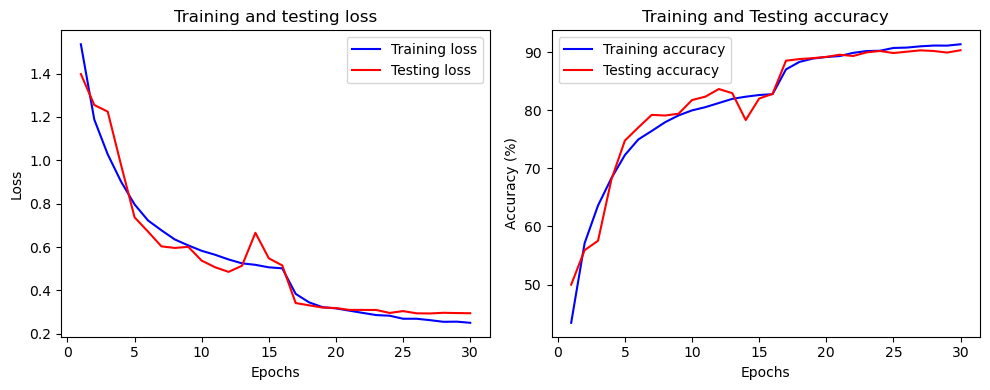

In [13]:
# Train the model
#train_model_bis(model, trainloader, testloader, epochs=num_epochs, is_scheduler=is_scheduler, is_mixup=is_mixup, save_dir="output")
train_model_bis(model, trainloader, testloader, epochs=num_epochs, is_scheduler=is_scheduler, is_mixup=is_mixup)

In [19]:
# # # Save the model
check_point = {
    "epoch": num_epochs,
    "model_state": model.state_dict(),
    "optimizer": "Adam",
    "optim_state": optimizer.state_dict() ,
    "is_weight": weight ,
    "is_scheduler": is_scheduler
}
if check_point["is_scheduler"]:
    check_point["scheduler"]=scheduler
    
torch.save(check_point, './model_state/resnet18.pth')

In [15]:
# # We load the dictionary
# loaded_cpt = torch.load('./model_state/resnet18_model_simple.pth')

# new_model = ResNet18()
# new_model.load_state_dict(loaded_cpt['model_state'])

In [16]:
# TO DO:

# 1) Presentation of the assigned paper (ResNet)

# 2) Hyperparameter exploration strategy (C10 full)

#   a) Architecture HP
#       - Type (ResNet, DenseNet, etc.)
#       - Depth (nb of layers)
#       - Width (nb of filter per layer, growthrate, etc.)

#   b) Training
#       - Optimizer (SGD, Adam, etc.)
#       - Learning rate, scheduler
#       - Nb of epochs
#       - Regularization ( weight decay)
#       - Data augmentation (to struggle overfitting)
#       - batch size


In [17]:
# Currently, we are underfitting, we have to overfit first then fight overfitting.
# I've increased the batch size and as a result, the accuracy and loss increased and decreased respectively. 
# However, the model is still not overfitting, why? -> No generalization power? Model capacity limitation? -> more layer? change the achitecture?
# --> use the full dataset to see if the problem is persisting 

# Do we have to remove the transform (DA) ?

In [18]:
# print head dataset
